## Replicate - DeepLOB: Deep Convolutional Neural Networks for Limit Order Books
(Paper authors: Zihao Zhang, Stefan Zohren, Stephen Roberts)

Dataset source: https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing

In [22]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense
from keras.callbacks import EarlyStopping

In [27]:
# # set random seed

# from tensorflow import set_random_seed
# set_random_seed(10)

# Data preparation

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons. 

In [2]:
train_fi = np.loadtxt('./data/Train_Dst_NoAuction_DecPre_CF_6.txt')

test_fi_1 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_6.txt')
test_fi_2 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_7.txt')
test_fi_3 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_8.txt')
test_fi_4 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_9.txt')
test_fi = np.hstack((test_fi_1, test_fi_2, test_fi_3,test_fi_4))

In [4]:
def extract_x_y_data(data, timestamp_per_sample):
    data_x = np.array(data[:40, :].T)
    data_y = np.array(data[-5:, :].T)
    [N, P_x] = data_x.shape
#     P_y = data_y.shape[1]
    
    x = np.zeros([(N-timestamp_per_sample+1), timestamp_per_sample, P_x])
    
    for i in range(N-timestamp_per_sample+1):
        x[i] = data_x[i:(i+timestamp_per_sample), :]
        
    x = x.reshape(x.shape + (1,))
        
    y = data_y[(timestamp_per_sample-1):]
    y = y[:,3] - 1
    y = np_utils.to_categorical(y, 3)
    
    return x, y

train_fi_x, train_fi_y = extract_x_y_data(train_fi, timestamp_per_sample=100)
test_fi_x, test_fi_y = extract_x_y_data(test_fi, timestamp_per_sample=100)

In [5]:
train_fi_x.shape

(217305, 100, 40, 1)

In [6]:
train_fi_y.shape

(217305, 3)

In [7]:
test_fi_x.shape

(176834, 100, 40, 1)

In [8]:
test_fi_y.shape

(176834, 3)

In [21]:
train_fi_x2, train_fi_y2, test_fi_x2, test_fi_y2 = train_fi_x[:30000,:,:,:], train_fi_y[:30000,:], test_fi_x[:3000,:], test_fi_y[:3000,:]

In [22]:
train_fi_x3, train_fi_y3, test_fi_x3, test_fi_y3 = train_fi_x[:100000,:,:,:], train_fi_y[:100000,:], test_fi_x[:20000,:], test_fi_y[:20000,:]

In [10]:
# trainX_CNN2, trainY_CNN2, testX_CNN2, testY_CNN2 = trainX_CNN[:10000,:,:,:], trainY_CNN[:10000,:], testX_CNN[:1000,:], testY_CNN[:1000,:]

In [11]:
# trainX_CNN3, trainY_CNN3, testX_CNN3, testY_CNN3 = trainX_CNN[10000:20000,:,:,:], trainY_CNN[10000:20000,:], testX_CNN[1000:2000,:], testY_CNN[1000:2000,:]

#### Hypter Parameters

In [12]:
lookback_timestep = 100
feature_num = 40

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

#LSTM param
LSTM_num = 64

#Activation param
leaky_relu_alpha = 0.01


#### Training Hyper Params

In [13]:
# categorical crossentropy loss
loss = 'categorical_crossentropy'

# ADAM is used
learning_rate = 0.01
adam_epsilon = 1
optimizer = Adam(lr=learning_rate, epsilon=1)

# accuracy is used for stopping training
metrics = ['accuracy']

#max epoch num is not specified in paper, use 120 because paper mentions training stops at about 100 epochs
num_epoch = 120
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 20
#mini-batch size 32 from paper
batch_size = 32


#### Inception module

we split the input into a small set of lowerdimensional representations by using 1 × 1 convolutions, transform the representations by a set of filters, here 3 × 1 and 5 × 1, and then merge the outputs. A max-pooling layer is used inside the Inception Module, with stride 1 and zero padding. “Inception@32” represents one module and indicates all convolutional layers have 32 filters in this module, and the approach is depicted schematically in Figure 4

In [14]:

def initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics):
    
    input_tensor = Input(shape=(lookback_timestep, feature_num, 1))
    
    # Conv block1
    print(input_tensor.shape)
    conv_layer1 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(input_tensor)
    print(conv_layer1.shape)
    conv_layer1 =LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_first1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)

    # Conv block2
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(conv_layer1)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)

    # Conv block3
    conv_layer3 = Conv2D(conv_filter_num, (1,10))(conv_layer2)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    
    # Inception module
    inception_module1 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print(inception_module1.shape)
    inception_module1 = Conv2D(inception_num, (3,1), padding='same')(inception_module1)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print(inception_module1.shape)

    inception_module2 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print(inception_module2.shape)
    inception_module2 = Conv2D(inception_num, (5,1), padding='same')(inception_module2)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print(inception_module2.shape)

    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same')(conv_layer3)
    print(inception_module3.shape)
    inception_module3 = Conv2D(inception_num, (1,1), padding='same')(inception_module3)
    print(inception_module3.shape)
    inception_module3 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module3)
    print(inception_module3.shape)
    
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    print(inception_module_final.shape)
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]))(inception_module_final)
    print(inception_module_final.shape)

    # LSTM
    LSTM_output = LSTM(LSTM_num)(inception_module_final)
    print(LSTM_output.shape)

    # Fully Connected Layer with softmax activation function for output
    model_output = Dense(3, activation='softmax')(LSTM_output)
    print(model_output.shape)
    
    DeepLOB_model = Model(inputs=input_tensor, outputs= model_output)  
    
    DeepLOB_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return DeepLOB_model


In [15]:
DeepLOB_model = initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics)

(None, 100, 40, 1)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 10, 16)
(None, 100, 10, 16)
(None, 100, 10, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 96)
(None, 100, 96)
(None, 64)
(None, 3)


# Model Training

In [26]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)
DeepLOB_model.fit(train_fi_x3, train_fi_y3, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(test_fi_x3, test_fi_y3), callbacks = [es])

Epoch 1/120
3125/3125 - 499s - loss: 1.0867 - accuracy: 0.3696 - val_loss: 1.0705 - val_accuracy: 0.3851
Epoch 2/120
3125/3125 - 475s - loss: 1.0854 - accuracy: 0.3712 - val_loss: 1.0669 - val_accuracy: 0.3920
Epoch 3/120
3125/3125 - 510s - loss: 1.0842 - accuracy: 0.3688 - val_loss: 1.0623 - val_accuracy: 0.3920
Epoch 4/120
3125/3125 - 496s - loss: 1.0839 - accuracy: 0.3699 - val_loss: 1.0638 - val_accuracy: 0.3965
Epoch 5/120
3125/3125 - 490s - loss: 1.0834 - accuracy: 0.3706 - val_loss: 1.0654 - val_accuracy: 0.3966
Epoch 6/120
3125/3125 - 469s - loss: 1.0833 - accuracy: 0.3683 - val_loss: 1.0604 - val_accuracy: 0.3972
Epoch 7/120
3125/3125 - 256s - loss: 1.0828 - accuracy: 0.3692 - val_loss: 1.0633 - val_accuracy: 0.3927
Epoch 8/120
3125/3125 - 252s - loss: 1.0817 - accuracy: 0.3750 - val_loss: 1.0569 - val_accuracy: 0.3957
Epoch 9/120
3125/3125 - 249s - loss: 1.0753 - accuracy: 0.3866 - val_loss: 1.0524 - val_accuracy: 0.4059
Epoch 10/120
3125/3125 - 249s - loss: 1.0707 - accuracy

Epoch 79/120
3125/3125 - 253s - loss: 0.4835 - accuracy: 0.8059 - val_loss: 0.7040 - val_accuracy: 0.7222
Epoch 80/120
3125/3125 - 252s - loss: 0.4839 - accuracy: 0.8049 - val_loss: 0.7348 - val_accuracy: 0.7129
Epoch 81/120
3125/3125 - 248s - loss: 0.4783 - accuracy: 0.8081 - val_loss: 0.7111 - val_accuracy: 0.7183
Epoch 82/120
3125/3125 - 247s - loss: 0.4756 - accuracy: 0.8086 - val_loss: 0.7028 - val_accuracy: 0.7246
Epoch 83/120
3125/3125 - 244s - loss: 0.4710 - accuracy: 0.8109 - val_loss: 0.7291 - val_accuracy: 0.7108
Epoch 84/120
3125/3125 - 254s - loss: 0.4684 - accuracy: 0.8128 - val_loss: 0.7136 - val_accuracy: 0.7218
Epoch 00084: early stopping


## Visualizations

In [57]:
file1 = open('./output/FI-2010-training-process.txt', 'r')
fi_lines = file1.readlines()
loss_value_list = []
accuracy_value_list = []
val_loss_value_list = []
val_accuracy_value_list = []
for i in range(len(fi_lines)):
    line = fi_lines[i]
    str_list = np.array(line.split(' '))
    if i % 2 == 1:
        loss_i = np.where(str_list == 'loss')[0][0]
        loss_value = float(str_list[loss_i + 1])
        accuracy_i = np.where(str_list == 'accuracy')[0][0]
        accuracy_value = float(str_list[accuracy_i + 1])
        val_loss_i = np.where(str_list == 'val_loss')[0][0]
        val_loss_value = float(str_list[val_loss_i + 1])
        val_accuracy_i = np.where(str_list == 'val_accuracy')[0][0]
        val_accuracy_value = float(str_list[val_accuracy_i + 1])

        loss_value_list.append(loss_value)
        accuracy_value_list.append(accuracy_value)
        val_loss_value_list.append(val_loss_value)
        val_accuracy_value_list.append(val_accuracy_value)
epoch_list = list(range(1,len(loss_value_list)+1))

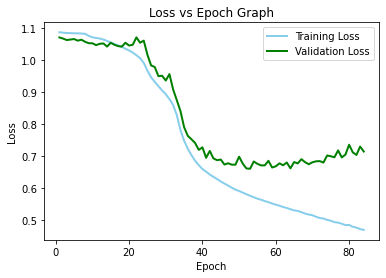

In [58]:
# multiple line plots
plt.plot(epoch_list, loss_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_loss_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Graph')
plt.legend(['Training Loss', 'Validation Loss'])

plt.savefig('./output/FI-2010 Loss Graph.png')
plt.show()

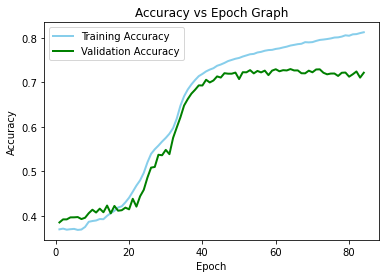

In [59]:
# multiple line plots
plt.plot(epoch_list, accuracy_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_accuracy_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.savefig('./output/FI-2010 Accuracy Graph.png')
plt.show()

In [60]:
JNJ_lines = open('./output/JNJ-training-process.txt', 'r').readlines()
loss_value_list = []
accuracy_value_list = []
val_loss_value_list = []
val_accuracy_value_list = []
for i in range(len(JNJ_lines)):
    line = JNJ_lines[i]
    str_list = np.array(line.split(' '))
    if i % 2 == 1:
        loss_i = np.where(str_list == 'loss:')[0][0]
        loss_value = float(str_list[loss_i + 1])
        accuracy_i = np.where(str_list == 'accuracy:')[0][0]
        accuracy_value = float(str_list[accuracy_i + 1])
        val_loss_i = np.where(str_list == 'val_loss:')[0][0]
        val_loss_value = float(str_list[val_loss_i + 1])
        val_accuracy_i = np.where(str_list == 'val_accuracy:')[0][0]
        val_accuracy_value = float(str_list[val_accuracy_i + 1])

        loss_value_list.append(loss_value)
        accuracy_value_list.append(accuracy_value)
        val_loss_value_list.append(val_loss_value)
        val_accuracy_value_list.append(val_accuracy_value)
epoch_list = list(range(1,len(loss_value_list)+1))

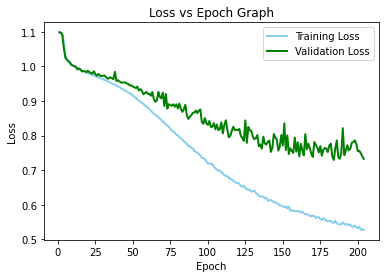

In [61]:
# multiple line plots
plt.plot(epoch_list, loss_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_loss_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Graph')
plt.legend(['Training Loss', 'Validation Loss'])

plt.savefig('./output/JNJ Loss Graph.png')
plt.show()

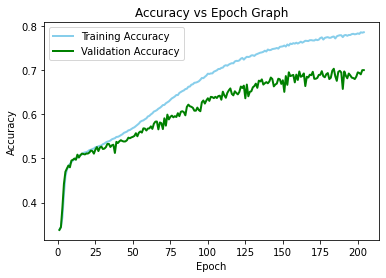

In [62]:
# multiple line plots
plt.plot(epoch_list, accuracy_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_accuracy_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.savefig('./output/JNJ Accuracy Graph.png')
plt.show()